In [ ]:
#Debugging done here
#Code changes to functions below must also be made in the .r files

In [33]:
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")
#install.packages("rbenchmark", repos='http://cran.us.r-project.org')

Installing package into 'C:/Users/Greig/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'BiocManager' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Greig\AppData\Local\Temp\RtmpCiXsdF\downloaded_packages


In [94]:
library(data.table)

In [ ]:
# BE CAREFUL NOT TO BE USING source() here because instead of debugging using functions
# defined here it will look to the R files

# to test that it works via command line go to the R model folder and run
# "C:/Program Files/R/R-3.6.1/bin/r.exe" CMD BATCH FIPEX_run_DCI.r

In [93]:
##############################################################################
# 
# FIPEX_run_DCI.r
#source("FIPEX_output_to_R_input.r")
FIPEX_output_to_R_input()
#source("dci_fxs.r")
x = try(dci_fxs(),silent=FALSE)

if(class(x)=='data.frame' | class(x)=='list'){
  write.table(x,file='out.txt')
} else{
  write("ERROR",file='out.txt')
}

      DCIp     DCId
1 30.03119 44.29823


In [24]:
##############################################################################
# FIPEX_run_DCI_Sectional.r
#source("FIPEX_output_to_R_input.r")
FIPEX_output_to_R_input()
#source("dci_fxs.r")
x = try(dci_fxs(all_sections=T),silent=FALSE)
if(class(x)=='data.frame' | class(x)=='list'){
  write.table(x,file='out.txt')
} else{
  write("ERROR",file='out.txt')
}

Error in isValidAdjMat(adjMat, edgemode) : 
  row and column names must match


In [ ]:
##############################################################################
# FIPEX_run_DCI_DistanceDecay.r
#source("FIPEX_output_to_R_input.r")
FIPEX_output_to_R_input()
#source("dci_fxs.r")
x = try(dci_fxs(dist_decay=T),silent=FALSE)
if(class(x)=='data.frame' | class(x)=='list'){
  write.table(x,file='out.txt')
} else{
  write("ERROR",file='out.txt')
}

In [71]:
##############################################################################
# FIPEX_output_to_R_input.r


##############################################################################
##############################################################################
    # Last modified August, 2020 by G Oldford
    # Inputs: 
    #   FIPEX_connectivity.csv
    #   FIPEX_BarrierHabitatLine.csv
    # Outputs: 
    #   segment_matrix.csv
    #   barrier.csv
    # Description:
    # 1) Creates segment_matrix.csv with columns: "Seg_ID","Seg"
    #   (connectivity table, "seg" = downstream segment)
    # 2) Creates barrier.csv that has columns: "Pass", "Bar_ID", "Seg_ID", 
    #  "nat_barrier"
    # 3) Creates length.csv with columns: "Seg_ID","Shape_Length"
    # 

FIPEX_output_to_R_input<-function(){
    ######################################################
    #### 1. PREPARE / CONVERT CONNECTIVITY TABLE ####
    connectivity_data<-read.csv("FIPEX_connectivity.csv")

    barrier<- as.vector(connectivity_data$BarrierOrFlagID)
    down_barrier<- as.vector(connectivity_data$Downstream_Barrier)

    # turn the barrier names into segment names by adding _s
    segment<-paste(as.vector(connectivity_data$BarrierOrFlagID),"_s",sep="")
    down_segment<-paste(as.vector(connectivity_data$Downstream_Barrier),"_s",sep="")

    # maintian the name of the closest segment to the start point of the riverscape as "sink"
    down_segment[down_segment=="Sink_s"]<-"sink"

    res<-NULL

    for(i in 1:length(segment)){
        # get the segment downstream	
        down<-down_segment[segment==segment[i]]
        
        # look for any matching segments in the downstream dataset
        additional_connected_segments<-segment[!is.na(match(down_segment,segment[i]))]
        connected_segments<-c(segment[i],down,additional_connected_segments)
        
        num_segments<-length(connected_segments)
        # rep - replicates values, second arg = x times
        newdata<-data.frame(rep(segment[i],num_segments),connected_segments)
        
        # make the names match what the R DCI functions expect
        names(newdata)<-c("Seg_ID","Seg")
        # rbind essentially appends rows
        res<-rbind(res,newdata)
        }

    # add in the origin, which is connected to itself and other segments next to it. 
    section_name<-"sink"
    additional_connected_segments<-segment[!is.na(match(down_segment,section_name))]
    connected_segments<-c(section_name,additional_connected_segments)
    num_segments<-length(connected_segments)
    newdata<-data.frame(rep(section_name,num_segments),connected_segments)
    names(newdata)<-c("Seg_ID","Seg")
    
    res<-rbind(res,newdata)

    write.table(x=res,
                file="segment_matrix.csv",
                row.names=F,
                sep=",")
    
    ######################################################
    #### 2. PREPARE / CONVERT BARRIER ATTRIBUTE TABLE ####
    # create the file barrier.csv that has columns: Pass	Bar_ID	Seg_ID	nat_barrier
    # this requires knowing the upstream and downstream segments of each barrier. 

    # read in the barrier passabilities
    barrier_info<-read.csv("FIPEX_BarrierHabitatLine.csv")
    #barrier.info$BarrierID[barrier.info$BarrierID=="Sink"]<-"1"

    # change the col names  
    barrier_info$barrier<-barrier_info$BarrierID
    barrier_info$pass<-barrier_info$BarrierPerm

    res2<-NULL

    for(i in 1:length(barrier))
        {
        upstream_segment<-paste(barrier[i],"_s",sep="")
        if(down_barrier[i]=="Sink") 
            downstream_segment <- "sink"
        else 
            downstream_segment<-paste(down_barrier[i],"_s",sep="")
    
        pass<-barrier_info$BarrierPerm[barrier_info$BarrierID==barrier[i]]
        nat_barrier<-barrier_info$NaturalYN[barrier_info$BarrierID==barrier[i]]
        #nat_barrier<-F
        
        newdata<-data.frame(rep(pass,2),
                            rep(barrier[i],2),
                            c(upstream_segment,downstream_segment),
                            rep(nat_barrier,2))
        
        names(newdata)<-c("Pass",
                          "Bar_ID",
                          "Seg_ID",
                          "nat_barrier")
        res2<-rbind(res2,newdata)
        }

    write.table(file="barrier.csv",
                res2,
                row.names=F,
                sep=",") 
    
    ######################################################
    #### 3. PREPARE / CONVERT SEGMENT LENGTH TABLE ####

    data<-read.csv("FIPEX_BarrierHabitatLine.csv")
    # the column names in the input file assumed to be: 
    # ObID, BarrierID, HabClass, Shape_Length, BarrierPerm, NaturalYN
    # the column names in the destination file are: Seg_ID, Shape_Length

    # changed by Greig (Oct 7,2010) - lengths<-data$Shape_Length
    lengths<-data$Quantity
    segment<-paste(as.vector(data$BarrierID),"_s",sep="")
    
    # maintain the name of the closest segment to the start point of the riverscape as "sink"
    segment[segment=="Sink_s"]<-"sink"
    newdat<-data.frame(segment,lengths)
    names(newdat)<-c("Seg_ID","Shape_Length")
    write.table(file="length.csv",
                newdat,
                row.names=F,
                sep=",")

    #print("Barrier.csv")
    #print(res2)
    #print("Segment_matrix.csv")
    #print(res)
    #print("length.csv")
    #print(newdat)
}


In [2]:
#connectivity_data
#segment
#connected_segments
#res

In [92]:
##############################################################################
# DCI_fxs.r

dci_fxs<-function(all_sections=F, dist_decay=F){

    #source in the 7 functions in R
    #see each function for an explanation of inputs and outputs

    #source("convert_gis_output_to_r_format.r")
    #source("get_adj_matrix_from_gis.r")
    #source("graph_fx.r")
    #source("sum_fx.r")
    #source("graph_and_data_setup_for_DCI.r")
    #source("dci_calc_fx.r")
    #source("dci_calc.r")

    convert_gis_output_to_r_format()
    adj_matrix<-get_adj_matrix_from_gis()
    
    #print(adj_matrix)
    #print(as.matrix(adj_matrix))

    #OLD note:
    #have to assign it an object name as this function gets called in 
    #in "graph.and.data.setup.for.DCI.r" and "sum.fx.r"
    
    # Note GLO - graph_fx actually returns an object
    graph_fx(plot_it=F, adj_matrix=adj_matrix)
    passability<-read.csv("segments_and_barriers.csv")

    NB<-graph_and_data_setup_for_DCI(passability=passability, adj_matrix=adj_matrix)
   
    dci_calc(NB,all_sections=all_sections)
}

In [58]:
##############################################################################
# convert_gis_output_to_r_format


##############################################################################
##############################################################################
    # Edited by: G Oldford
    # Last modified: August, 2020 (minor changes, no changes to logic)
    # Input: barrier.csv with columns: "Pass", "Bar_ID", "Seg_ID", 
    #  "nat_barrier"
    #
    # Input example: 
    # "Pass","Bar_ID","Seg_ID","nat_barrier"
    # 0.5,55152,"55152_s",FALSE

    # Output: segments_and_barriers.csv with colu,ns: "passability", 
    #   "barrier id", "segment 1 (start)", "segment 2 (end)", "nat_barrier",
    #   "section 1.2" (binding segment 1 and segment 2 - for use in another function)
    #
    # Output example: 
    # "Bar_ID","Seg_1","Seg_2","Pass","nat_barrier","section1_2"
    # 55152,"55152_s","sink",0.5,FALSE,"55152_s,sink"

    # Notes from previous coding work: 
    #  barrier.csv contains barrier ID, the passability for each barrier and 
    # the segments that border the barrier
   
convert_gis_output_to_r_format<-function(){
    
    barrier=read.csv("barrier.csv")
    
    # if the barrier.csv file actually has no barriers in it (i.e. barrier$Pass 
    # has 1's down the entire column),
    # then we want to stop the algorithm and let the user know that their riverscape 
    # is one without natural or artificial barriers. 
    if (length(barrier$Pass)== sum(barrier$Pass)) 
        {
        stop("
        *** There are no artificial or natural barriers in the riverscape. ***
        *** All passability values in your barrier.csv file are 1 ***
        *** Analysis will not proceed past this point. ***")
    }else{

        unique_barriers<-with(barrier, unique(Bar_ID))
        #extract unique barrier IDs to later match them up with Bar_ID
        #and get the 2 sections/segments that neighbour the barrier

        segments_and_barriers<-NULL

        for (i in 1:length(unique_barriers)){
            #find in which *position* there is a match between barrier$Bar_ID and unique barriers
            index<-match(barrier$Bar_ID,unique_barriers[i])
        
            section_pair<-barrier$Seg_ID[!is.na(index)]
            
            #obtain the passability value by matching the barrier ID
            passability<-barrier$Pass[match(unique_barriers[i],barrier$Bar_ID)]

            #determine whether it is a natural or artificial barrier
            barrier_type<-barrier$nat_barrier[match(unique_barriers[i],barrier$Bar_ID)]

            # get barrier id (old note: you can't concatenate a factor and numbers 
            # (i.e. section name (a letter) with barrier ID and passability (numbers)), 
            #so you have to turn it into a list)
            barrier_id<-list(unique_barriers[i])
            sections_and_barriers<-data.frame(barrier_id,
                                              section_pair[1],
                                              section_pair[2],
                                              passability,
                                              barrier_type)
            names(sections_and_barriers)<-c("Bar_ID","Seg_1","Seg_2","Pass","nat_barrier")
        
            # Old Note
            #use these column headings as these are the headings that Christina uses in 
            # her ArcGIS output files
            segments_and_barriers<-rbind(segments_and_barriers, sections_and_barriers)
        }

        # Old Note
        #we want to get information for both directions between segments e.g. 1 to 2 as well as the 2 to 1
        #create a column where we paste the start and end segments (separated by a comma)
        rev_segments_and_barrier<-segments_and_barriers
        
        # Below does not work in newer versions of R - GO, 2020
        #names(rev_segments_and_barriers)<-c("Bar_ID","Seg_2","Seg_1","Pass","nat_barrier")
        #rev_segments_and_barriers<-rev_segments_and_barriers[,c(1,3,2,4,5)]
        # Recoded temporarily (should be done using dplyr)
        # ***********************************************************
        names(rev_segments_and_barrier)[names(rev_segments_and_barrier) == "Seg_1"] <- "Seg_2a"
        names(rev_segments_and_barrier)[names(rev_segments_and_barrier) == "Seg_2"] <- "Seg_1a"

        names(rev_segments_and_barrier)[names(rev_segments_and_barrier) == "Seg_2a"] <- "Seg_2"
        names(rev_segments_and_barrier)[names(rev_segments_and_barrier) == "Seg_1a"] <- "Seg_1"
        
        segments_and_barriers<-rbind(segments_and_barriers,rev_segments_and_barrier)
        segments_and_barriers$section1_2<-with(segments_and_barriers,paste(Seg_1,Seg_2, sep=","))

        write.table(segments_and_barriers, 
                    "segments_and_barriers.csv", 
                    row.names=F, 
                    sep=",")
    } 
}

In [77]:
##############################################################################
# get_adj_matrix_from_gis

    # purpose: produce an adjancy matrix
    # Last modified: August, 2020 by G Oldford
    # Input: segment_matrix.csv (connectivity table) with columns: "Seg_ID","Seg"
    #         (seg and seg_id are segments, seg is downstream of seg_id, segment 
    #          names are based on downstream neighbour node)
    # Output: adjacency_matrix.csv - binary matrix with 1's and 0's indicating 
    #         segment neighbours
    #
    # Input example: 
    # "Seg_ID","Seg"
    # "55152_s","55152_s"
    # "55152_s","sink"

    #
    # Output example: 
    #  matrix object of 
    #  0's and 1's indicating neighbours (directed?)
    #  (note, aug 2020: the CSV was not being used - see below)
    #
    # Notes from previous coding work: 
    #The input is the segment matrix, which is really two vectors. For each 
    #segment in the first column (Seg_ID), the second column (Seg) gives the id 
    #of other sections it touches, including itself.

get_adj_matrix_from_gis<-function(){

    segment_matrix=read.csv("segment_matrix.csv")
    # obtain the segments in whatever order they are in the file
    segments<-with(segment_matrix, unique(Seg_ID))

    #create a matrix with only 0's in them
    adj_matrix<-matrix(nrow=length(segments), 
                       ncol=length(segments), 
                       rep(0,length(segments)*length(segments)))
    segment_length<-length(segments)
    print(adj_matrix)
    rownames(adj_matrix)<-colnames(adj_matrix)<-segments

    for (i in 1:segment_length){
        # find the segments in segment.matrix$Seg where segment.matrix$Seg_ID matches segments[i]
        # index of matching positions - this will be a vector of 1's and NA's
        pos_match<-	match(segment_matrix$Seg_ID,segments[i])
        
        # keep only the positions where pos.match==1
        adj_segments<-segment_matrix$Seg[!is.na(pos_match)]

        # find the column positions that correspond to the adjacaent segments
        col<-match(adj_segments,segments)

        # the row number should correspond to i
        row<-i

        # assign a value of 1 for all values of row and col
        adj_matrix[row,col]<-1
    }

    write.table(adj_matrix,
                "adjacency_matrix.csv",
                row.names=F, sep=",")

    # Old Note
    #write.table seems to give problems when reading in "adjacency matrix.csv" - 
    # it doesn't recognize that it's a matrix so it creates column rows with headings "X1,X2,X3,..."
    # instead of "1,2,3,..."
    #in order to avoid the problem above return the object:
    
    
    return(adj_matrix)

}

### 2020 Distance Decay Code

In [146]:
FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")
FIPEX_table

ObID,NodeEID,NodeLabel,Quantity_Len,HabLenUnits,Quantity_Area,HabAreaUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<fct>,<fct>,<dbl>,<fct>
1,83,6,568.73,km,0,km^2,1,FALSE,Sink,Sink,568.73,km
2,84,D,804.20,km,0,km^2,0,FALSE,83,6,804.20,km
3,96,7,973.69,km,0,km^2,1,FALSE,83,6,973.69,km
4,98,E,670.25,km,0,km^2,0,FALSE,84,D,670.25,km
5,94,A,1424.25,km,0,km^2,0,FALSE,96,7,1424.25,km
6,97,B,514.14,km,0,km^2,0,FALSE,96,7,514.14,km
7,99,F,698.75,km,0,km^2,0,FALSE,98,E,698.75,km
8,95,2,856.91,km,0,km^2,1,FALSE,94,A,856.91,km
9,100,C,1585.28,km,0,km^2,0,FALSE,97,B,1585.28,km


In [526]:
# for testing natural TF set node 84 to natural barrier
FIPEX_table[2,]$NaturalTF <- TRUE
FIPEX_table

ObID,NodeEID,NodeLabel,Quantity_Len,HabLenUnits,Quantity_Area,HabAreaUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<fct>,<fct>,<dbl>,<fct>
1,83,6,568.73,km,0,km^2,1,FALSE,Sink,Sink,568.73,km
2,84,D,804.20,km,0,km^2,0,TRUE,83,6,804.20,km
3,96,7,973.69,km,0,km^2,1,FALSE,83,6,973.69,km
4,98,E,670.25,km,0,km^2,0,FALSE,84,D,670.25,km
5,94,A,1424.25,km,0,km^2,0,FALSE,96,7,1424.25,km
6,97,B,514.14,km,0,km^2,0,FALSE,96,7,514.14,km
7,99,F,698.75,km,0,km^2,0,FALSE,98,E,698.75,km
8,95,2,856.91,km,0,km^2,1,FALSE,94,A,856.91,km
9,100,C,1585.28,km,0,km^2,0,FALSE,97,B,1585.28,km


In [2]:
# required libraries
library(RBGL)
library(Rgraphviz)
library(rbenchmark)
library(data.table)
library(tidyverse)

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: grid
-- Attaching packages -----------------------------

### Create Adjacency Matrix from FIPEX Output

In [147]:
###### CREATE ADJACENCY MATRIX #####
# rbgl requires adjacency matrix 
# FIPEX outputs adjacency table so need to convert
# note: igraph requires only adjacency table

# library(rbenchmark) can be used to test
#https://stackoverflow.com/questions/34355892/build-a-square-adjacency-matrix-from-data-frame-or-data-tablelevs <- unique(unlist(neighbournodes_all, use.names=F))


create_adjmatrix_2020 <- function(neighbournodes_all,option="2020_tapply") {
    # binary adjacency matrix defining connectivity
    
    if(option=="2020_tapply"){
        neighbournodes_all$edgeLength <- 1
        adj_matrix <- with(neighbournodes_all, tapply(edgeLength, list(Node1, Node2),FUN=length, default = 0))
        
    }else if(option=="2020_dfmatrix"){
        matrix_table <- table(neighbournodes_all)
        adj_mat1 <- as.data.frame.matrix(matrix_table)
        adj_matrix <- as.matrix(adj_mat1)
        
    }else if(option=="oldway"){
        
        # pre-2020 code
        segments<-with(neighbournodes_all, unique(Node2))
        #create a matrix with only 0's in them
        adj_matrix<-matrix(nrow=length(segments), 
                       ncol=length(segments), 
                       rep(0,length(segments)*length(segments)))
        segment_length<-length(segments)
        rownames(adj_matrix)<-colnames(adj_matrix)<-segments

        for (i in 1:segment_length){
            # find the segments in segment.matrix$Seg where segment.matrix$Seg_ID matches segments[i]
            # index of matching positions - this will be a vector of 1's and NA's
            pos_match<-	match(neighbournodes_all$Node2,segments[i])
        
            # keep only the positions where pos.match==1
            adj_segments<-neighbournodes_all$Node1[!is.na(pos_match)]

            # find the column positions that correspond to the adjacaent segments
            col<-match(adj_segments,segments)

            # the row number should correspond to i
            row<-i

            # assign a value of 1 for all values of row and col
            adj_matrix[row,col]<-1
        }
    }  
    adj_matrix
}

# check (need neighbournodes_all to check)
# dimensions should match
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_tapply"))
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"))
#dim(create_adjmatrix_2020(neighbournodes_all,"oldway"))

In [148]:
totalhabitatarea = sum(FIPEX_table$Quantity_Area)
totalhabitatlength = sum(FIPEX_table$Quantity_Len)
totallength = sum(FIPEX_table$DownstreamNeighDistance)
print("For cross checks in GIS:")
print(totalhabitatarea)
print(totalhabitatlength)
print(totallength)

[1] "For cross checks in GIS:"
[1] 0
[1] 14887.19
[1] 14887.19


In [149]:
library(tidyverse)
library(data.table)

#FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")

totalhabitatarea = sum(FIPEX_table$Quantity_Area)
totalhabitatlength = sum(FIPEX_table$Quantity_Len)
totallength = sum(FIPEX_table$DownstreamNeighDistance)

# first just ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))

# get connectivity info only and convert columns to character,
# fix "Sink" to "sink"
FIPEX_table_reg <- FIPEX_table %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = as.character(NodeEID)) %>%
mutate(NodeEID = temp) %>%
mutate(temp = as.character(DownstreamEID)) %>%
mutate(DownstreamEID = temp) %>%
select(-temp) %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",DownstreamEID))

# downstream neighbours
neighbournodes_down <- FIPEX_table_reg

# self-connected
neighbournodes_self <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(DownstreamEID = NodeEID)

# upstream neigbours
neighbournodes_up <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = DownstreamEID) %>%
mutate(DownstreamEID = NodeEID) %>%
mutate(NodeEID = temp) %>%
select(NodeEID, DownstreamEID)

# merge
neighbournodes_all <- neighbournodes_down %>% bind_rows(neighbournodes_self) %>%
bind_rows(neighbournodes_up) %>%
add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
rename(Node1 = NodeEID, Node2 = DownstreamEID)

In [713]:
# benchmark ways of creating adjacency matrix
library(rbenchmark)
benchmark(create_adjmatrix_2020(neighbournodes_all,"2020_tapply"),
create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
create_adjmatrix_2020(neighbournodes_all,"oldway"),
replications=1000)
# tapply fastest

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,"create_adjmatrix_2020(neighbournodes_all, ""2020_dfmatrix"")",1000,0.61,2.905,0.61,0,NA,NA
1,"create_adjmatrix_2020(neighbournodes_all, ""2020_tapply"")",1000,0.21,1.000,0.21,0,NA,NA
3,"create_adjmatrix_2020(neighbournodes_all, ""oldway"")",1000,0.34,1.619,0.35,0,NA,NA


In [150]:
################################################################
# produce binary connectivity matrix - useful for regular DCI

adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"2020_tapply")
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"oldway"

# produce copy with zeros on diagonal for visuals
adj_matrix_zeros_on_diag<- adj_mat_new
# diag() is a core R function - GO
diag(adj_matrix_zeros_on_diag)<-0

################################################################
# produce edge-weighted connectivity matrix - for DCI w/ DD
# nodes / edges are not reversed as in original way
# do not need self-connected

# get connectivity info, convert columns to characters
FIPEX_table_DD <- FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
mutate(temp = as.character(NodeEID)) %>%
mutate(NodeEID = temp) %>%
mutate(temp = as.character(DownstreamEID)) %>%
mutate(DownstreamEID = temp) %>%
select(-temp) %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",DownstreamEID))

# downstream neighbours
edges_down <- FIPEX_table_DD

# upstream neigbours
edges_up <- FIPEX_table_DD %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
mutate(temp = DownstreamEID) %>%
mutate(DownstreamEID = NodeEID) %>%
mutate(NodeEID = temp) %>%
select(-temp)

# self-connected
#FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
#mutate(NodeEID = DownstreamEID, DownstreamNeighDistance = 0.1)

# merge
edges_all <- edges_down %>%
bind_rows(edges_up) %>%
#add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
rename(Node1 = NodeEID, Node2 = DownstreamEID, edgeLength = DownstreamNeighDistance)

adj_matrix_edgelengths <- with(edges_all, tapply(edgeLength, list(Node1, Node2), FUN=sum, default = 0))

In [151]:
adj_matrix_edgelengths

,100,101,102,83,84,94,95,96,97,98,99,sink
100,0.00,2335.07,0.00,0.00,0.00,0.00,0.00,0.00,1585.28,0.00,0.00,0.00
101,2335.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4455.92,0.00
83,0.00,0.00,0.00,0.00,804.20,0.00,0.00,973.69,0.00,0.00,0.00,568.73
84,0.00,0.00,0.00,804.20,0.00,0.00,0.00,0.00,0.00,670.25,0.00,0.00
94,0.00,0.00,0.00,0.00,0.00,0.00,856.91,1424.25,0.00,0.00,0.00,0.00
95,0.00,0.00,0.00,0.00,0.00,856.91,0.00,0.00,0.00,0.00,0.00,0.00
96,0.00,0.00,0.00,973.69,0.00,1424.25,0.00,0.00,514.14,0.00,0.00,0.00
97,1585.28,0.00,0.00,0.00,0.00,0.00,0.00,514.14,0.00,0.00,0.00,0.00
98,0.00,0.00,0.00,0.00,670.25,0.00,0.00,0.00,0.00,0.00,698.75,0.00


### Create Graph Object

In [ ]:
#to do: alternative graph creation using igraph
# benchmark
# note most code below assumes using an RGBL Boost GraphAM object,
#  so to test alternative it would require a lot of alternative code,
#  potentially

In [152]:
################################################################
# CREATE GRAPH OBJECT for DCI w/ Distance Decay
# GO -  "length" (alternative - "weight") attribute to graph edges
# the value = 1 means default is 1 for non-zeros in adj matrix
# actual lengths should be represented by the non-zero values in the 
# adjacency matrix
# #https://www.rdocumentation.org/packages/graph/versions/1.50.0/topics/graphAM-class
library(RBGL)
library(Rgraphviz)

# Create graph object
# 2020 - note this is a different way to call the graphAM function 
# vs pre-2020
g_dd <- graphAM(adjMat=adj_matrix_edgelengths,  edgemode="directed", values=list(weight=1))

# associate passabilities with nodes using NodeData slot
# e.g. nodeData(g,n=c("b", "c"), attr ="color") <- "red"
nodeDataDefaults(g_dd, attr ="pass") <- 1.0
nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="pass") <- as.double(FIPEX_table$BarrierPerm)
nd <- nodes(g_dd)

nodeDataDefaults(g_dd, attr ="nodelabel") <- "none"
nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="nodelabel") <- as.character(FIPEX_table$NodeLabel)
nodeData(g_dd,n="sink", attr="nodelabel") <- "sink"
nd <- nodes(g_dd)

nodeDataDefaults(g_dd, attr ="downnodelabel") <- "none"
nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="downnodelabel") <- as.character(FIPEX_table$DownstreamNodeLabel)
nd <- nodes(g_dd)

nodeDataDefaults(g_dd, attr ="natural") <- "none"
nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="natural") <- FIPEX_table$NaturalTF
nodeData(g_dd,n="sink", attr="natural") <- FALSE
nd <- nodes(g_dd)

# optionally can give edges attributes
#edgeDataDefaults(g_dd, attr="name")<-"noname"
#edgeData(self, from, to, attr)
#edgeData(self, from, to, attr) <- value
edgeDataDefaults(g_dd, attr="HabLen")<-0.0
edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="HabLen")<-as.double(FIPEX_table$Quantity_Len)

# reverse - attr associated with each direction along one edge
edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="HabLen")<-as.double(FIPEX_table$Quantity_Len)

edgeDataDefaults(g_dd, attr="HabArea")<-0.0
edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="HabArea")<-as.double(FIPEX_table$Quantity_Area)
# reverse - attr associated with each direction along one edge
edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="HabArea")<-as.double(FIPEX_table$Quantity_Area)

# give edges an easy-to-access name insensitive to direction
# this is done to quickly identify duplicates later
# there may be alternatives such as accessing edgeNames but I suspect
# they are slower than this
edgeDataDefaults(g_dd, attr="EdgeNameGO")<-"init"
edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")
# reverse - attr associated with each direction along one edge
edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")


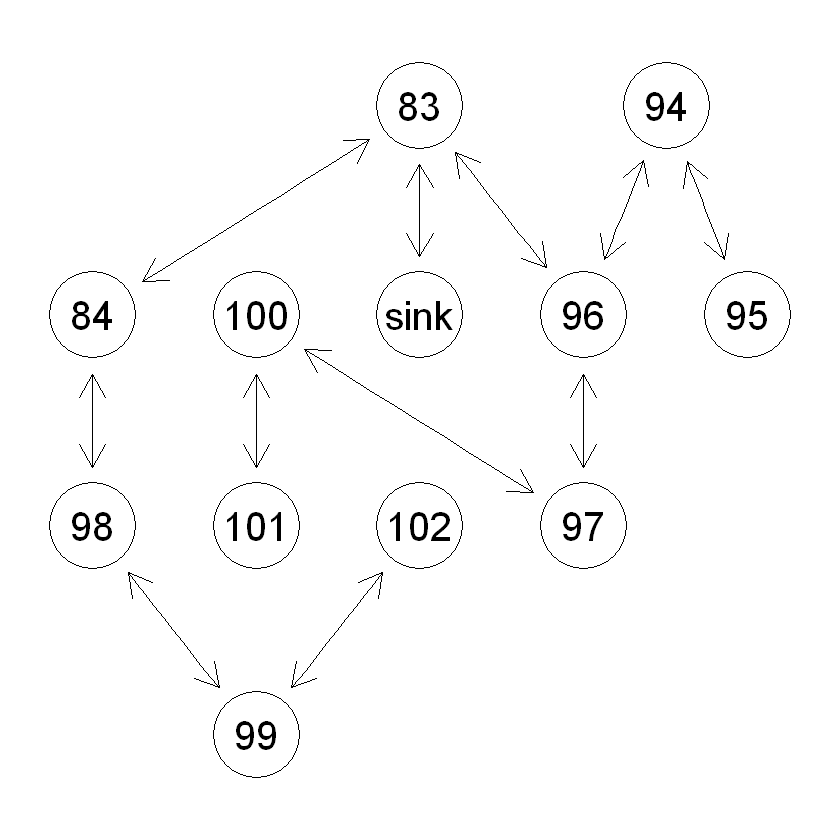

In [153]:
# note ignore the bidirectional arrows
plot(g_dd)

In [10]:
################################################################################
## TRACE NETWORK FUNCTION
# get all distances and paths (from penult) to all nodes from Sink / all nodes
# https://www.rdocumentation.org/packages/RBGL/versions/1.48.1/topics/dijkstra.sp

get_paths_distances <- function(g=NULL,fromnode="sink"){
    dijkstra.sp(g,fromnode,eW=unlist(edgeWeights(g)))
    
    # TO DO: ALTERNATIVES FOR BENCHMARKING
}

paths_distances_sink <- get_paths_distances(g_dd,"sink")

In [12]:
paths_distances_sink$distances["101"]

101 
3920.35

In [ ]:
# to do, add param to function for Natural TF
# to do, add attr to nodeData for Natural TF

In [154]:
##############################################################################
##### SUMMARY TABLE 2020 #####

# get cumulative passability each sink-node pair using path info
# and get other attributes
# add cumulativepass by looping back through the paths to each node from sink
#   (this does not seem to be most efficient possible way but cannot edit the 
#     source for Djikstra.sp because it's actually an interface to C++ 'Boost'
#     library for graphs)

# pseudocode:
# for each 'from node' (e.g., sink in DCId, and all nodes in DCIp)
# for each node in 'all paths' results (from the 'from node' to all other nodes)
#   get the first edge len and hab traversed from node to sink
#
#   store length and hab of the edge between to node and next node in path 
#     towards sink

#   do while next node name <> "sink"
#     pass = nodeData(g_dd, nextnode, "pass")
#     cumulativepass =  cumulativepass * pass
#     nextnode = the next node in path towards sink
#     if last edge traversed on the way to sink
#       store the length and habitat of this edge
#   
#   add various other attributes to master table (attr's stored in g object)

library(data.table)
# data.table vs other options likely to speed things up for large networks
#https://rstudio-pubs-static.s3.amazonaws.com/406521_7fc7b6c1dc374e9b8860e15a699d8bb0.html
#https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist

get_summary_tab_2020 <- function(option="dt-lists",
                                naturalonly=FALSE,
                                g = NULL,
                                DCIp=FALSE){
    # option is for benchmarking speed of appending to table
    # naturalonly will calculate pass-weighted path distances
    #  while ignoring non-natural barriers
    # initialize empty data object in different ways
    
    # for different options and benchmarking:
    DT2 = data.table(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 FromEdgeHabLen=0.0,
                 ToEdgeHabLen=0.0,
                 FromEdgeHabArea=0.0,
                 ToEdgeHabArea=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init")
    
    DF2 = data.frame(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 FromEdgeHabLen=0.0,
                 ToEdgeHabLen=0.0,
                 FromEdgeHabArea=0.0,
                 ToEdgeHabArea=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init", stringsAsFactors=F)
    
    # lists in R must be pre-allocated a size 
    # size of our table is almost n^2 - n*(n-1) 
    # since not getting distance from a node to itself
    if(DCIp==FALSE){
        outlist <- vector("list", length(numNodes(g_dd)))
    }else{
        outlist <- vector("list", length(numNodes(g_dd)*(numNodes(g_dd)-1)))   
    }
    outlist[[numNodes(g_dd)]] <- list(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 FromEdgeHabLen=0.0,
                 ToEdgeHabLen=0.0,
                 FromEdgeHabArea=0.0,
                 ToEdgeHabArea=0.0,
                 FromEdgeName="init",
                 ToEdgeName="init",
                 ToFromEdgeNameCombo="init")

    # from = sink / start node
    # to = other nodes
    if(DCIp==FALSE){
        fromnodecount=1
    }else{
        fromnodecount=numNodes(g_dd)
    }
    
    # if DCId only need to do paths and sum table to / from sink
    # otherwise need to cycle through all nodes and do sum table
    # for all paths between all nodes 
    count = 0
    for (j in 1:fromnodecount){
    #indendation for two nested for loops not done to save space
        if(DCIp==FALSE){
            fromnode_name = "sink"
            fromnode_label = "sink" 
        }else{
            fromnode_name = nodes(g_dd)[j]
             if (fromnode_name=="sink"){
                fromnode_label = "sink"
            }else{
                fromnode_label = nodeData(g_dd, fromnode_name, "nodelabel")[[1]]  
            }
        }
        
        ###########################################################
        # get path & distances between 'fromnode' and all other nodes
        paths_distances <- get_paths_distances(g,fromnode_name)
        
        
    for (k in 1:length(paths_distances$penult)) {
        
        tonode <- paths_distances$penult[k]     
        tonode_name = names(tonode)
        tonode_name <- tonode_name[[1]]
        tonode_label = nodeData(g_dd, tonode_name, "nodelabel")[[1]]
    
        if (tonode_name == fromnode_name){
            # not interested in distance from one node to itself
            next
        }
        count = count+1
        # initialize
        cumulativepass = 1.0
        pass = 1.0 # watch not to take pass from to/from end nodes since traversal starts at edge
        totaldistance = paths_distances$distances[tonode_name]
        totaldistance <- totaldistance[[1]]     
        
        # get length of edge 
        nextnode = paths_distances$penult[tonode]
        nextnode_name = names(nextnode)
        lastnode_name = tonode_name
    
        # get the last edge length traversed on the way to 'to node'
        # alternatively could grab the weight for this edge instead of subtraction
        toedgelen = totaldistance - paths_distances$distances[nextnode_name]
        toedgelen <- toedgelen[[1]]
        toedgedata =edgeData(g_dd, tonode_name,nextnode_name)
        toedgehablen = toedgedata[[1]]$HabLen
        toedgehabarea = toedgedata[[1]]$HabArea
        toedgename = toedgedata[[1]]$EdgeNameGO
        
        exitvar = "go"
        while (exitvar != "stop"){
        
            if(nextnode_name != fromnode_name){
                pass = nodeData(g_dd, nextnode_name, "pass")
                if(naturalonly==FALSE){
                    cumulativepass = cumulativepass * pass[[1]]
                }else{
                    natural = nodeData(g_dd,nextnode_name,"natural")
                    if(natural[[1]]==TRUE){
                        cumulativepass = cumulativepass * pass[[1]]
                    }
                }
            }else{
                fromedgelen = paths_distances$distances[lastnode_name]
                fromedgelen <- fromedgelen[[1]]
                fromedgedata = edgeData(g_dd, lastnode_name,fromnode_name)
                fromedgehablen = fromedgedata[[1]]$HabLen
                fromedgehabarea = fromedgedata[[1]]$HabArea
                fromedgename = fromedgedata[[1]]$EdgeNameGO
                
                exitvar="stop"
            }
            
            lastnode_name = nextnode_name
            nextnode = paths_distances$penult[nextnode]
            nextnode_name = names(nextnode)
        }
        
        distminusstartendlen = totaldistance - toedgelen - fromedgelen
       tofromedgename_combo = paste(toedgename,fromedgename,sep="|")
        
        if (option=="dt"){
            #print(cumulativepass)
            #https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist
            DT1 = data.table(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     FromEdgeHabLen=fromedgehablen,
                     ToEdgeHabLen=toedgehablen,
                     FromEdgeHabArea=fromedgehabarea,
                     ToEdgeHabArea=toedgehabarea,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            l = list(DT1,DT2)
            
            DT2 = rbindlist(l, use.names=TRUE)
        }else if(option=="dt-lists"){
            # append lists to list rather than work yet with tables
            DL1 = list(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     FromEdgeHabLen=fromedgehablen,
                     ToEdgeHabLen=toedgehablen,
                     FromEdgeHabArea=fromedgehabarea,
                     ToEdgeHabArea=toedgehabarea,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print("Length DL1: ")
            #print(length(DL1))
            outlist[[count]] <- (DL1)
            
        }else if(option=="df"){
            DF1 = data.frame(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     FromEdgeHabLen=fromedgehablen,
                     ToEdgeHabLen=toedgehablen,
                     FromEdgeHabArea=fromedgehabarea[[1]],
                     ToEdgeHabArea=toedgehabarea,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(fromedgehabarea)
            #print(DF1)
            DF2 <- rbind(DF2, DF1)
          }else if(option=="df-lists"){
            DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     FromEdgeHabLen=as.numeric(fromedgehablen),
                     ToEdgeHabLen=as.numeric(toedgehablen),
                     FromEdgeHabArea=as.numeric(fromedgehabarea),
                     ToEdgeHabArea=as.numeric(toedgehabarea),
                     FromEdgeName=as.character(fromedgename),
                     ToEdgeName=as.character(toedgename),
                     ToFromEdgeNameCombo=as.character(tofromedgename_combo))
            outlist[[count]] <- (DL1)
        }else if(option=="dplyr"){
             DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     FromEdgeHabLen=as.numeric(fromedgehablen),
                     ToEdgeHabLen=as.numeric(toedgehablen),
                     FromEdgeHabArea=as.numeric(fromedgehabarea),
                     ToEdgeHabArea=as.numeric(toedgehabarea),
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(row1)
            DF2 <- bind_rows(DF2,DL1)
        }
    } #k
    } #j
        
    if(option=="dt"){
        
        DT2
    }else if(option=="dt-lists"){
        DT2 <- data.table(rbindlist(outlist))
        
        DT2
    }else if(option=="df"){
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        DF2
    }else if(option=="df-lists"){
        DF2 <- data.frame(do.call(rbind, outlist))
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        DF2
    }else if(option=="dplyr"){
        DF2
    }
} #function


In [184]:
# example useage
# warning 'df-lists' does not work - it creates list type columns
#    which will cause errors in DCI calc!
sum_tab_2020 <- get_summary_tab_2020(option="dt-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE
                    )
sum_tab_2020 

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,FromEdgeHabLen,ToEdgeHabLen,FromEdgeHabArea,ToEdgeHabArea,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
100,101,C,8,1,2335.07,2335.07,2335.07,-2335.07,2335.07,2335.07,0,0,100-101,100-101,100-101|100-101
100,102,C,9,0,1585.28,4455.92,9702.23,3661.03,1585.28,4455.92,0,0,97-100,99-102,99-102|97-100
100,83,C,6,0,1585.28,973.69,3073.11,514.14,1585.28,973.69,0,0,97-100,83-96,83-96|97-100
100,84,C,D,0,1585.28,804.20,3877.31,1487.83,1585.28,804.20,0,0,97-100,83-84,83-84|97-100
100,94,C,A,0,1585.28,1424.25,3523.67,514.14,1585.28,1424.25,0,0,97-100,96-94,96-94|97-100
100,95,C,2,0,1585.28,856.91,4380.58,1938.39,1585.28,856.91,0,0,97-100,94-95,94-95|97-100
100,96,C,7,0,1585.28,514.14,2099.42,0.00,1585.28,514.14,0,0,97-100,96-97,96-97|97-100
100,97,C,B,1,1585.28,1585.28,1585.28,-1585.28,1585.28,1585.28,0,0,97-100,97-100,97-100|97-100
100,98,C,E,0,1585.28,670.25,4547.56,2292.03,1585.28,670.25,0,0,97-100,84-98,84-98|97-100


In [140]:
class(sum_tab_2020)

[1] "data.table" "data.frame"

### benchmarking different approaches to summary table creation

In [162]:
# test with a large (1000's nodes) dataset 
library(rbenchmark)

benchmark(get_summary_tab_2020(option="dt",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dt-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dplyr",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          replications=40)

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,"get_summary_tab_2020(option = ""df-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,2.21,1.014,2.20,0.00,NA,NA
3,"get_summary_tab_2020(option = ""df"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,13.56,6.220,12.68,0.04,NA,NA
5,"get_summary_tab_2020(option = ""dplyr"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,2.28,1.046,2.28,0.00,NA,NA
2,"get_summary_tab_2020(option = ""dt-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,2.18,1.000,2.11,0.00,NA,NA
1,"get_summary_tab_2020(option = ""dt"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,5.13,2.353,4.97,0.00,NA,NA


In [183]:
sum_tab_2020

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,FromEdgeHabLen,ToEdgeHabLen,FromEdgeHabArea,ToEdgeHabArea,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
100,101,C,8,1,2335.07,2335.07,2335.07,-2335.07,2335.07,2335.07,0,0,100-101,100-101,100-101|100-101
100,102,C,9,0,1585.28,4455.92,9702.23,3661.03,1585.28,4455.92,0,0,97-100,99-102,99-102|97-100
100,83,C,6,0,1585.28,973.69,3073.11,514.14,1585.28,973.69,0,0,97-100,83-96,83-96|97-100
100,84,C,D,0,1585.28,804.20,3877.31,1487.83,1585.28,804.20,0,0,97-100,83-84,83-84|97-100
100,94,C,A,0,1585.28,1424.25,3523.67,514.14,1585.28,1424.25,0,0,97-100,96-94,96-94|97-100
100,95,C,2,0,1585.28,856.91,4380.58,1938.39,1585.28,856.91,0,0,97-100,94-95,94-95|97-100
100,96,C,7,0,1585.28,514.14,2099.42,0.00,1585.28,514.14,0,0,97-100,96-97,96-97|97-100
100,97,C,B,1,1585.28,1585.28,1585.28,-1585.28,1585.28,1585.28,0,0,97-100,97-100,97-100|97-100
100,98,C,E,0,1585.28,670.25,4547.56,2292.03,1585.28,670.25,0,0,97-100,84-98,84-98|97-100


In [218]:
#options: DCIp, DCIs, dd (yes/no), cutoff_dist, dd_equation

########################################################
###### Calculate DCI #####
#dci_calc_2020_dd <- function(){}
# warning: the sum_tab_2020 must be a data.table
#          only some data frames work ('dplyr' is ok not
#          the 'df-lists' option)

naturalonly = FALSE
DCIp = FALSE
DCIs = FALSE

#### (1) DCId - calc_DCId ####
calc_DCId <- function(sum_tab_2020=NULL,
                      FromNode="sink"){
    
    # filter table
    DCId_data<-subset(sum_tab_2020,FromNode=="sink")
    
    # Credit to Chris Edge Code for avoiding loops in R here: 
    DCId_data$temp <- DCId_data$CumulativePass * (DCId_data$ToEdgeHabLen/totalhabitatlength)
    DCId <- sum(DCId_data$temp)
    DCId
} # DCId

#### (2) DCIp - calc_DCIp ####
# Credit to C Edge for shorter code
calc_DCIp <- function(sum_tab_2020=NULL,
                      option="unique"){
    
    # 'option' = unique / distinct for benchmarking speeds
    # sometimes sum_tab may be a data.table sometimes data.frame
    
    #if(class(sum_tab_2020)=="data.table"){
    if(option=="unique"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    }else{
        sum_tab_2020 <- distinct(sum_tab_2020, ToFromEdgeNameCombo, .keep_all = TRUE)
    }

    DCIp <- 0
    for (i in 1:nrow(sum_tab_2020)) {
        DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$ToEdgeHabLen[i]/totalhabitatlength) * (sum_tab_2020$FromEdgeHabLen[i]/totalhabitatlength))
    }
    DCIp
}

#### (3) DCIs - calc_DCIs ####
# can be added into (2) as option see below
calc_DCIs <- function (sum_tab_2020=NULL){
    # note GO 2020: DCIs is like running DCId in that duplicate edges
    # do not need removal from sum_tab as in DCIp
    # DCIs also differs from DCIp because the 'start edge' is not multiplied 
    # by end edge (which is similar to DCId)
    DCIp <- 0
    outlist <- vector("list", nrow(sum_tab_2020))
    # store pass weighted hab accessible from each edge
    for (i in 1:nrow(sum_tab_2020)) {
        DCIs <- (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$ToEdgeHabLen[i]/totalhabitatlength))
        outlist[[i]] <- list(FromNode=sum_tab_2020$FromNode[i],DCIs_1=DCIs) 
    }
    # summarize pass weighted hab accessible by edge ID
    # (using a 'node oriented approach') - could cause issues
    microDCI <- data.table(rbindlist(outlist))
    DCIs <- microDCI[, lapply(.SD,sum), by=.(FromNode)]
    DCIs
}

calc_DCId(sum_tab_2020,"sink")
calc_DCIp(sum_tab_2020,"unique")
calc_DCIs(sum_tab_2020)


[1] 0.287832

[1] 0.2159199

FromNode,DCIs_1
<chr>,<dbl>
100,0.26333714
101,0.15685096
102,0.29931236
83,0.28783202
84,0.33285395
94,0.34539225
95,0.05756022
96,0.28783202
97,0.39431820


In [160]:
# test with a large (1000's nodes) dataset 
library(rbenchmark)

benchmark(calc_DCIp(sum_tab_2020,"unique"),
          calc_DCIp(sum_tab_2020,"distinct"),
          replications=1000)
# unique is faster (data.table) vs distinct (dplyr)

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,"calc_DCIp(sum_tab_2020, ""distinct"")",1000,1.36,1.023,1.27,0.00,NA,NA
1,"calc_DCIp(sum_tab_2020, ""unique"")",1000,1.33,1.000,1.00,0.17,NA,NA


In [ ]:
# notes and examples
# isAdjacent will come in handy in graphAM class
#edgeData(g_dd, "83","sink", "HabLen")

#g1<-new("graphAM",adjMat=adj_mat_new,edgemode="directed")
#g2<-new("graphAM",adjMat=adj_matrix_zeros_on_diag,edgemode="directed")

#nodeData(g_dd, "94", "pass")
# note this returns a 'named' vector so have to get value of it using [[1]]

In [212]:
# crosscheck DCIp (this is old way of calculating)
OLD_table=read.csv("summary_table_all.csv")

DCIp <- 0
for (i in 1:nrow(OLD_table)) {
    DCIp <- DCIp + (OLD_table$pathway_pass[i] * (OLD_table$start_section_length[i]/totalhabitatlength) * (OLD_table$finish_section_length[i]/totalhabitatlength))
}
print(DCIp)
#totalhabitatlength
#OLD_table$start_section_length

[1] 0.2159199


In [211]:
#TO DO: problem with DCI_s because of node based start for analysis instead of edge based

# let's see if DCI_s is same as DCI_p 
# not quite. DCIs needs the summary table to be grouped by segment / node
# and DCIs does not need duplicate edge combos removed (compared to DCIp)

#my 2020 code
#sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
#note the DCI_s is like
DCIs_2020 <- function (){
DCIp <- 0
outlist <- vector("list", nrow(sum_tab_2020))
for (i in 1:nrow(sum_tab_2020)) {
    #DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$ToEdgeHabLen[i]/totalhabitatlength) * (sum_tab_2020$FromEdgeHabLen[i]/totalhabitatlength))
    DCIs <- (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$ToEdgeHabLen[i]/totalhabitatlength))
    outlist[[i]] <- list(FromNode=sum_tab_2020$FromNode[i],DCIs_1=DCIs) 
}
microDCI <- data.table(rbindlist(outlist))
microDCI[, lapply(.SD,sum), by=.(FromNode)]
#sum(microDCI$DCIs_1)
}



# re-written from old code
# (cross-checked with FIPEX DCI_s)
DCIs_old <- function(){
nodes <- nodes(g_dd)
for (i in 1:length(nodes(g_dd))){
    DCI_s<-0
    node_sum_tab<-subset(sum_tab_2020, FromNode==nodes(g_dd)[[i]])
    for (a in 1:nrow(node_sum_tab)){
        la<-node_sum_tab$ToEdgeHabLen[a]/totalhabitatlength
        pass_d<-node_sum_tab$CumulativePass[a]
        DCI_s<-DCI_s+(la*pass_d)
    }
    #print(nodes(g_dd)[[i]])
    print(DCI_s)
}
}

# cross check new way / old way of DCIs
DCIs_2020()
DCIs_old()


FromNode,DCIs_1
<chr>,<dbl>
100,0.26333714
101,0.15685096
102,0.29931236
83,0.28783202
84,0.33285395
94,0.34539225
95,0.05756022
96,0.28783202
97,0.39431820


[1] 0.2633371
[1] 0.156851
[1] 0.2993124
[1] 0.287832
[1] 0.332854
[1] 0.3453922
[1] 0.05756022
[1] 0.287832
[1] 0.3943182
[1] 0.09195825
[1] 0.3462487
[1] 0.287832


In [209]:
library(rbenchmark)

benchmark(DCIs_2020(),
          DCIs_old(),
          replications=1000)

# new way faster

test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DCIs_2020(),1000,3.22,1.000,2.09,0.37,NA,NA
DCIs_old(),1000,5.56,1.727,4.15,0.74,NA,NA


In [ ]:
# don't need loop. Change and benchmark.

calc_DCIp <- function(sum_tab_2020=NULL,
                      option="unique"){
    
    # 'option' = unique / distinct for benchmarking speeds
    # sometimes sum_tab may be a data.table sometimes data.frame
    
    #if(class(sum_tab_2020)=="data.table"){
    if(option=="unique"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    }else{
        sum_tab_2020 <- distinct(sum_tab_2020, ToFromEdgeNameCombo, .keep_all = TRUE)
    }

    DCIp <- 0
    for (i in 1:nrow(sum_tab_2020)) {
        DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$ToEdgeHabLen[i]/totalhabitatlength) * (sum_tab_2020$FromEdgeHabLen[i]/totalhabitatlength))
    }
    DCIp
}

In [178]:
node_sum_tab

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,FromEdgeHabLen,ToEdgeHabLen,FromEdgeHabArea,ToEdgeHabArea,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
sink,100,sink,C,0,568.73,1585.28,3641.84,1487.83,568.73,1585.28,0,0,sink-83,97-100,97-100|sink-83
sink,101,sink,8,0,568.73,2335.07,5976.91,3073.11,568.73,2335.07,0,0,sink-83,100-101,100-101|sink-83
sink,102,sink,9,0,568.73,4455.92,7197.85,2173.20,568.73,4455.92,0,0,sink-83,99-102,99-102|sink-83
sink,84,sink,D,1,568.73,804.20,1372.93,0.00,568.73,804.20,0,0,sink-83,83-84,83-84|sink-83
sink,94,sink,A,1,568.73,1424.25,2966.67,973.69,568.73,1424.25,0,0,sink-83,96-94,96-94|sink-83
sink,95,sink,2,0,568.73,856.91,3823.58,2397.94,568.73,856.91,0,0,sink-83,94-95,94-95|sink-83
sink,96,sink,7,1,568.73,973.69,1542.42,0.00,568.73,973.69,0,0,sink-83,83-96,83-96|sink-83
sink,97,sink,B,1,568.73,514.14,2056.56,973.69,568.73,514.14,0,0,sink-83,96-97,96-97|sink-83
sink,98,sink,E,0,568.73,670.25,2043.18,804.20,568.73,670.25,0,0,sink-83,84-98,84-98|sink-83


In [ ]:
# Old notes
    #########  ALL SECTION ANLAYSIS  ######
    ## if desired, one can calculate the DCI_d starting with every section.  This
    ## gives a "section-level" DCI score for each section in the watershed
    if(all_sections==T){
        sections<-as.vector(unique(sum_table$start))
        # store the all section results in DCI.as
        DCI_as<-NULL
        
        for(s in 1:length(sections)){
            DCI_s<-0
            # Old notes:
            # select out only the data that corresponds to pathways from one sectino 
            # to all other sections
            d_nrows<-subset(sum_table, start==sections[s])
            d_sum_table<-d_nrows
            
            for (a in 1:dim(d_nrows)[1]){
                # Old note:
                #to get the DCI for diadromous fish, use the following formula: 
                # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                la<-d_sum_table$finish_section_length[a]/sum(lengths$Shape_Length)
                pass_d<-d_sum_table$pathway_pass[a]
                DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
            } # end loop over sections for dci calc
        
            DCI_as[s]<-DCI_s
        } # end loop over "first" sections	

        # STORE RESULTS IN .CSV file
        res<-data.frame(sections,DCI_as)
        write.table(x=res,
                file="DCI_all_sections.csv",
                sep=",",
                row.names=F)

    } # end if statement over all.sections

    print(DCI)

    #write.table(DCI,"DCI.csv", row.names=F, sep=",")

    return(DCI)

In [90]:
##############################################################################
# graph_fx

# Edited by: G Oldford
    # Last modified: August, 2020
    # Inputs: 
    #   adjacency_matrix (from object or file?)
    #   segments_and_barriers.csv
    #   length.csv
    # Output:
    #   directed graph object for further analysis
    #
    #
    # Notes:
    #  this mainly does visuals
    #  rbgl and rgraphviz are both part of the bioconductor r package
    #  rbgl is a connector to the BOOST graph visualization library
    # the new("graphAM") is calling the graph library (also part of bioconductor)
    #   note AM = adjacency matrix
    # I believe adding the rbgl library also adds the graph library
    #
    # to-do: the function is reading an adjacency matrix from CSV
    # but in the master function it passes an adj_matrix object
    # with note that this is to avoid some issue of writing to CSV with 
    # headings. Should fix / sort this out. -GO, 2020
    
    #
    # Notes from previous coding work: 
    #  Problem with adjusting node.size.  If edge.size is changed, the font 
    #  size on the graph changes, if the node.size is changed, nothing is 
    #  changed on the graph.  
    #  Note: the larger the edge.size number, the smaller the font.


graph_fx<-function(edge_size=75,
                   node_size=5,
                   #adj_matrix=read.csv("adjacency_matrix.csv"),
                   adj_matrix=adj_matrix,
                   plot_it=F){
    
    # debug (comment below out in functions)
    #adj_matrix=read.csv("adjacency_matrix.csv")
    #edge_size=75
    #node_size=5
    #plot_it=F
    
    # to do: should not be embedded in function
    library(Rgraphviz)
    library(RBGL)
    
    #print(adj_matrix)
    #print("check")
    #rownames(adj_matrix)<-1:length(adj_matrix)
    #colnames(adj_matrix)<-1:length(adj_matrix)
    #print("check")

    #need to convert the dataframe into a matrix
    adj_matrix<-as.matrix(adj_matrix)
    
    passability<-read.csv("segments_and_barriers.csv")
    #this is the output from the "convert.gis.output.to.r.format.r" Crimson Editor file
    #data contained in this file: "Bar_ID","Seg_1","Seg_2","Pass","nat_barrier", "section1_2" (pasting Seg_1 and Seg_2 together)

    lengths<-read.csv("length.csv")
    #contains the total length of each segment (i.e. segment id and segment length)
    sections<-rownames(adj_matrix)

    #to create a graph without self-pointing edges going from 1 to 1, or 2 to 2, or etc... 
    #need to put zeros along the diagonal
    adj_matrix_zeros_on_diag<-adj_matrix

    # note diag is a core R function - GO
    diag(adj_matrix_zeros_on_diag)<-0


    if(plot_it==T){
        #### PLOT VISUAL GRAPH ####

        g1<-new("graphAM",
                adjMat=adj_matrix_zeros_on_diag, 
                edgemode="directed")
        #for the graph, note that the adj.matrix.zeros.on.diag must have 0s across the diagonal or else it will give you more edges, because it would include a-a, b-b, c-c, etc...

        #we want to label edges of the graph with the Barrier letter and the passability value
        #need to create a new column in passability that gives you: Bar_ID (Passability)
        #round the passability values to 2 decimal places (so it fits better on the page)
        pass_barrier<-passability
        pass_barrier$bar_pass<-with(pass_barrier,paste(Bar_ID," (",round(Pass,2),")",sep=""))

        #deal with EDGES
        eAttrs<-list()

        #need to assign correct labeling in Graph
        #create new labels in pass.barrier that match graph object labels 
        # (edgeNames(g1)/names(eAttrs$labels))
        pass_barrier$names.eAttrs<-with(pass_barrier, paste(Seg_1, Seg_2, sep="~"))

        #determine the right order:
        #the "match" must be done in this order so that we know the position of where the 
        # 1st element of edgeNames(g1) matches with pass.barrier$names.eAttrs
        ord<-match(edgeNames(g1),pass_barrier$names.eAttrs)
        
        # order the dataframe appropriately wrt the ord and pass.barrier dataframes
        pass_barrier<-data.frame(pass_barrier)[ord,]

        #assign the text we want to appear with each edge
        ew<-pass_barrier$bar_pass
        
        # get the labels of the edges
        names(ew)<-edgeNames(g1)
        
        # assign graph object labels so it it knows where to put the text
        eAttrs$label<-ew

        #deal with NODES
        nAttrs<-list()

        #get segment names
        n<-nAttrs$label
        n<-row.names(adj_matrix)
        names(n)<-nodes(g1)

        # fontsize for edges 
        a<-rep(edge_size,length(ew))
        names(a)<-edgeNames(g1)
        eAttrs$fontsize<-a

        # fontsize for nodes 
        b<-rep(node_size, length(nodes(g1)))
        names(b)<-nodes(g1)
        nAttrs$fontsize<-b

        #overall it looks like font size of the nodes and edges don't work independently from eachother

        #node shape
        node_shape<-rep("ellipse",length(nodes(g1)))
        names(node_shape)<-nodes(g1)
        nAttrs$shape<-node_shape

        #node height
        node_height<-rep(4,length(nodes(g1)))
        names(node_height)<-nodes(g1)
        nAttrs$height<-node_height

        #node width
        node_width<-rep(1.1,length(nodes(g1)))
        names(node_width)<-nodes(g1)
        nAttrs$width<-node_width
        
        #edge color
        edge_color<-rep("grey",length(ew))
        names(edge_color)<-edgeNames(g1)
        eAttrs$color<-edge_color

        plot(g1,edgeAttrs=eAttrs, nodeAttrs=nAttrs, main="_______ Watershed")
        #gives a graph with a 2-way arrow
    }

    #print(adj_matrix)
    g2<-new("graphAM",
            adjMat=adj_matrix, 
            edgemode="directed")
    #use g2 for the graph.and.data.setup.for DCI function - you need 1's along the diagonal

    return(c(sections,g2))

}

In [197]:
#rownames(adj_matrix)
#adj_matrix


In [60]:
##############################################################################
# graph_and_data_setup_for_DCI.r

# Edited by: G Oldford
    # Last modified: August, 2020
    # Inputs: 
    #  adj_matrix, passability, lengths
    # Output:
    #  "summary_table_natural.csv" with passability values of each pathway 
    #   if there were no artificial barriers (the natural passability of the 
    #   riverscape)
    # "summary_table_all.csv" with passability values 
    #   of the pathways in the given riverscape (artificial and natural barriers 
    #   included).  This way we can have an idea of how much the artificial barriers
    #   are really affecting the DCI of the riverscape.
    #
    # Output example:
    #  "start","end","path2","barrier_id","pathway_pass","start_section_length","finish_section_length"
    #  "55152_s","55152_s","55152_s","NA",1,120.1,120.1
    #  "55152_s","62689_s","55152_s,sink,62689_s","55152,62689",0.25,120.1,452.2
    #
    # Notes:
    #  this function calls sum_fx for natural only and natural / anthro barriers
    #
    # to-do: 
    
    #
    # Notes from previous coding work: 
    #dci.fxs.r assigns adj.matrix and passability before it runs the graph.and.data.setup.for.DCI.r	
    #output: get the summary tables of all possible pathways with their passability values, 
    # start and end sections, barrier id, length of start and end segments
    #calls on "sum.fx.r" function

graph_and_data_setup_for_DCI<-function(adj_matrix,
                                       passability,
                                       lengths){
    # checks if any barriers are flagged as natural - GO, 2020
    NB<-sum(passability$nat_barrier==TRUE)>0
    
    #NB = natural barriers
    if (NB==TRUE){
        # Old note:
        # if there are natural barriers in the system, we want to know what the 
        # overall DCInp and DCInd (n= natural) is for the system so we can compare 
        # it to the DCIap and DCIad (a= all (anthropogenic + natural barriers))
        natural_passability<-passability
        # Old note:
        # only want to take into consideration passability values for natural barriers.  
        # so we want to change the passability values for anthropogenic barriers to 1
        natural_passability$Pass[natural_passability$nat_barrier==FALSE]<-1

        sum_table_n<-sum_fx(adj_matrix=adj_matrix, 
                            passability=natural_passability,
                            lengths=lengths)
        write.table(sum_table_n,
                    "summary_table_natural.csv",
                    row.names=F,
                    sep=",")
    }
    # Old note:
    #if you put the else statement here, then it will only do the below commands 
    # only if the above statement is false.  if you take the else statement out, 
    # it will do the above commands only if it's true, but it will ALWAYS do the 
    # commands below.

    sum_table<-sum_fx(adj_matrix=adj_matrix, 
                      passability=passability,
                      lengths=lengths)

    write.table(sum_table,
                "summary_table_all.csv",
                row.names=F,
                sep=",")

    return(NB)
}

In [61]:
##############################################################################
# sum_fx.r

# Edited by: G Oldford
    # Last modified: August, 2020
    # purpose: calculate paths between segments and produce sum_tab
    # Inputs: 
    #   adj_matrix
    #   passability
    #   lengths (opening the csv and replacing param)
    # Output:
    #   sum_table
    #
    # Output example: 
    #  "start","end","path2","barrier_id","pathway_pass","start_section_length","finish_section_length"
    #  "55152_s","55152_s","55152_s","NA",1,120.1,120.1
    #  "55152_s","62689_s","55152_s,sink,62689_s","55152,62689",0.25,120.1,452.2
    #
    #
    # Notes 2020:
    #  this is the only function other than the visualization function graph_fx() 
    # that uses the graphing library (rbgl)
    #
    # to-do: 
    
    #
    # Notes from previous coding work: 
    #function(adj.matrix, passability) calls on "adj.matrix" and "passability" that were 
    #created in previous functions.  When you call a function, it creates a bunch of 
    # objects, but these objects disappear when you open a new function.  In order to 
    # be able to use these objects, you can either "assign(object.name)", or you can do 
    # what was done above function(object.names).  Because all of these functions are 
    # called in "dci.fxs.r" and "dci.fxs.theo.restoration.r", the information is passed 
    # on from one function to another.
    # WHAT THIS FUNCTION DOES: it creates all the data for a summary table (start and end 
    # segments, pathway, barriers it goes through, passability, length of start and end
    # segments)
    # BUT this dataframe is NOT outputted into Excel in this function.  It's returned and 
    # then called in by graph.and.data.setup.for.DCI.r.

sum_fx<- function(adj_matrix,
                  passability,
                  lengths) {



    # why is 'lengths' used as a function param if it's declared again here -GO, 2020
    lengths<-read.csv("length.csv")

    x2<-NULL #section start
    y2<-NULL #section end
    start_section_length<-NULL
    finish_section_length<-NULL
    path2<-NULL
    pathway_pass<-NULL
    barrier_id<-NULL

    # obtain the section names from the adj matrix
    sections<-rownames(adj_matrix)
    
    # code useful later?
    # added by GO to fix issue with adj_matrix
    #rownames(adj_matrix)<-1:length(adj_matrix)
    #colnames(adj_matrix)<-1:length(adj_matrix)
    #convert the dataframe into a matrix
    #adj_matrix<-as.matrix(adj_matrix)
    
    # Old note:
    # there is a problem with only one barrier, since sp.between requires a list, 
    # and we provide a vector.
    # A quick work-aroud is to manually calcualte the DCI with only one barrier 
    # and skip the more complicated steps below
    if(length(sections)>2){
        
        # this object is re-created here when it was created in previous function
        # - GO, 2020
        g2<-new("graphAM",
                adjMat=adj_matrix, 
                edgemode="directed")
        
        # Old note:
        # get a list of adjacent sections (i.e. find all possible pathways that 
        # exist in the riverscape)
        for (i in 1:length(sections)){
            
            # Old note:
            #need it to look through the matrix, "i" cycles down the columns and 
            #"j" cycles across the rows
            for (j in 1:length(sections)){

                x<-sections[i]
                y<-sections[j]
                
                # sp.between is a RBGL function for shortest path (Dijkstra's) -GO
                #sp.between = shortest path between 2 nodes
                path_all<-sp.between(g=g2,start=x,finish=y)
                
                #extract every possible pair that exists in the matrix
                #pulls out the path information for each pair of sections
                #e.g. [1] "1" "2" "3" - to go from 1 to 3 you must go through 2
                path<-path_all[[1]]$path_detail
                
                path_length<-length(path)
                # we need to get the length so that the k-loop (below) can pull out 
                # the appropriate barrier information 

                #we have all of the possible combinations that exist between 
                # sections, we now need to find the barriers that exist bewteen these sections

                x2<-c(x2,x)
                y2<-c(y2,y)
                
                #grab the 1st segment of the path
                start_section<-path[1]
                                
                #grab the last segment of the path
                finish_section<-path[path_length]

                #get the length of the start and finish segments of the pathway
                new_start_length<-lengths$Shape_Length[match(start_section, lengths$Seg_ID)]
                new_finish_length<-lengths$Shape_Length[match(finish_section, lengths$Seg_ID)]

                start_section_length<-c(start_section_length, new_start_length)
                finish_section_length<-c(finish_section_length, new_finish_length)

                section1_2<-NULL
                section_1<-NULL
                section_2<-NULL

                if (path_length<2){
                    section1_2<-NA
                }else{
                    for(k in 1:(path_length-1)){
                        #use "-1" because we are looking at the number of barriers between 
                        # each section.  number of barriers is = to number of sections - 1.
                        section1<-path[k]
                        section2<-path[k+1]
                        #k+1 is used so that R knows to go to the 2nd element in path

                        section_1<-c(section_1, section1)
                        section_2<-c(section_2, section2)

                        section_paste<-paste(section1,section2,sep=",")
                        section1_2<-c(section1_2, section_paste)
                        #need to create this new column, section1_2, in order to match it to 
                        #passability$section1_2 - see function "graph.fx.r ### INPUT DATA ###"
                    }
                }
    
                #find the barriers that are between each pair of sections
                all_barriers<-passability$Bar_ID[match(section1_2,passability$section1_2)]
                
                #give a list of all of the passability values from start to end of the path
                new_barrier_pass2<-passability$Pass[match(all_barriers,passability$Bar_ID)]

                #need to get the product for each new.barrier.pass$all.passabilities
                #add a new column to the new.barrier.pass dataframe
                new_barrier_pass<-prod(new_barrier_pass2)
                pathway_pass<-c(pathway_pass,new_barrier_pass)

                #now we need to turn these objects into 1 vector in order to use cbind to make 
                # these objects into 1 dataframe
                new_barrier_id<-paste(all_barriers,sep="",collapse=",")
                barrier_id<-c(barrier_id, new_barrier_id)

                path1<-paste(path,collapse=",")
                #we want to get "a" "b" "c" to be 1 character (i.e. "a,b,c")
                #this allows it to be recognized as 1 element in the dataframe
                path2<-c(path2,path1)
            }

            sum_table<-cbind(x2, 
                             y2, 
                             path2, 
                             barrier_id, 
                             pathway_pass, 
                             start_section_length, 
                             finish_section_length)
            sum_table<-as.data.frame(sum_table)
            sum_table$pathway_pass<-as.numeric(as.character(sum_table$pathway_pass))
            sum_table$start_section_length<-as.numeric(as.character(sum_table$start_section_length))
            sum_table$finish_section_length<-as.numeric(as.character(sum_table$finish_section_length))
            sum_table$pathway_pass[is.na(sum_table$pathway)]<-1
            names(sum_table)[1:2]<-c("start","end")	
        }
    # close if loop to check to see if ther are more than one barriers        
    }else{

        sum_table<-data.frame
        # old note:
        # "sink" has to appear twice in the start column, 
        # and the second section has to appear twice in the end
 
        start<-c(sections[1],
                 sections[1],
                 sections[2],
                 sections[2])
        end<-c(sections[1],
               sections[2],
               sections[1],
               sections[2])
        path2<-c(sections[1],
                 paste(sections,collapse=","),
                 paste(rev(sections),collapse=","),
                 sections[2])
        barrier_id<-c("NA",
                      passability$Bar_ID[1],
                      passability$Bar_ID[1],
                      "NA")
        pathway_pass<-c(1,
                        passability$Pass[1],
                        passability$Pass[1],
                        1)
        start_section_length<-lengths$Shape_Length[match(start, lengths$Seg_ID)]
        finish_section_length<-lengths$Shape_Length[match(end, lengths$Seg_ID)]
        sum_table<-data.frame(start,
                              end,
                              path2,
                              barrier_id,
                              pathway_pass,
                              start_section_length,
                              finish_section_length)
    }

#print("sum table")
#print(sum_table)
    return(sum_table)
}


In [238]:
#sum_table

In [62]:
##############################################################################
# dci_calc.r

# 
    # Last modified:
    # Inputs: 
    #   summary_table_all.csv
    #   length.csv
    #   summary_table_natural.csv
    #   NB (true/false)
    #
    # Output:
    #   DCIn.csv
    #   DCIa.csv
    #   prop_of_DCI_n.csv
    #
    # Output example: 
    #
    #
    # Notes:
    #  
    #
    # to-do: 
    
    #
    # Notes from previous coding work: 

dci_calc<-function(NB,
                   lengths=read.csv("length.csv"),
                   sum_table_all=read.csv("summary_table_all.csv"),
                   all_sections=F){
    #calls upon the "dci.calc.fx.r function"
    #NB=F
    #lengths=read.csv("length.csv")
    #sum_table_all=read.csv("summary_table_all.csv")
    #all_sections=F
    
    
    if (NB==T){
        sum_table_nat<-read.csv("summary_table_natural.csv")
        # Old note:
        #this dataframe was created in the "graph.and.data.setup.for.DCI.r" 
        # Crimson Editor file dataframe includes start and end segments, 
        # pathway, barriers in pathway, passability for the pathway, and the 
        # length of the start and end segments
        DCI_n<-dci_calc_fx(sum_table=sum_table_nat,
                           lengths=lengths)
        write.table(DCI_n,
                    "DCIn.csv", 
                    row.names=F, 
                    sep=",")
    }

    # old note:
    #the summary table all.csv dataframe was created in the 
    # "graph.and.data.setup.for.DCI.r" Crimson Editor file
    #it includes start and end segments, pathway, barriers 
    # in pathway, passability for the pathway, and the length 
    # of the start and end segments

    DCI_a<-dci_calc_fx(sum_table=sum_table_all,
                       lengths=lengths,
                       all_sections=all_sections)
    write.table(DCI_a,"DCIa.csv", 
                row.names=F, 
                sep=",")

    if (NB==T){
    #returns the results (but you can't do anything after this, so "return" 
    # must always be at the end of a function)
        prop_of_DCI_n<-round(DCI_a/DCI_n,3)
        write.table(prop_of_DCI_n,
                    "prop_of_DCI_n.csv",
                    row.names=F, 
                    sep=",")

        res<-data.frame(unlist(c(DCI_a,
                                 DCI_n,
                                 prop_of_DCI_n)))
        row.names(res)<-c("DCI_P (Total)",
                          "DCI_D (Total)",
                          "DCI_P (nat. barriers only)",
                          "DCI_D (nat. barriers only)",
                          "DCI_P (prop.of natural)",
                          "DCI_D (prop.of natural)")
        names(res)<-"value"
        return(res)
    }else{
        res<- data.frame(t(DCI_a))
        names(res)<-"value"
        return(res)
    }

}


In [73]:
##############################################################################
# dci_calc_fx.r

# 
    # Last modified: 
    # Inputs: 
    #   sum_table  
    #   lengths
    #   all_sections (t/f)
    #
    # Output:
    #   DCI
    #
    # Output example: 
    #   DCIp     DCId
    #   30.03119 44.29823
    #
    # Notes:
    #  
    #
    # to-do: 
    
    #
    # Notes from previous coding work: 

dci_calc_fx<-function(sum_table,
                      lengths,
                      all_sections=F){

    # Old Notes
    #sum.table is a variable that is used in the dci.calc.r function, 
    #where we describe sum.table as sum.table.all or sum.table.nat
    #where: sum.table.nat<-read.csv("summary table natural.csv") and 
    #sum.table.all<-read.csv("summary table all.csv") - from the 
    #graph.and.data.setup.for.DCI.r function

    #WHAT THIS FUNCTION DOES: it calculates the DCIp and DCId 
    #values for the riverscape (includes both natural and 
    #artificial barriers)

    #this contains the length of each section

    #use this number for the DCIp calculation - i
    # interested in movements in all directions from all segments
    #print("check")
    p_nrows<-dim(sum_table)[1]
    #print("check")
    d_nrows<-subset(sum_table, 
                    start=="sink")
    #for diadromous fish we are only interested in the movement 
    # from the segment which is closest to the ocean
    d_sum_table<-d_nrows

    DCIp<-0
    DCId<-0

    #DCIp calculation
    for (k in 1:p_nrows){
        # Old notes: 
        #to get the riverscape connectivity index for potadromous fish, 
        #use the given formula: DCIp= Cij*(li/L)*(lj/L)
        #Cij = passability for pathway (product of all barrier passabilities 
        #in the pathway), li & lj = length of start and finish sections, 
        #L = total length of all sections

        lj<-sum_table$start_section_length[k]/sum(lengths$Shape_Length)
        lk<-sum_table$finish_section_length[k]/sum(lengths$Shape_Length)
        pass<-sum_table$pathway_pass[k]
        DCIp<-DCIp+lj*lk*pass*100
    
        #add DCIp at the beginning to keep a running total of DCIp values
    }

    #DCId calculation
    for (a in 1:dim(d_nrows)[1]){
        # Old notes:
        #to get the DCI for diadromous fish, use the following formula: 
        # DCId= li/L*Cj (where j= the product of the passability in the pathway)
        
        la<-d_sum_table$finish_section_length[a]/sum(lengths$Shape_Length)
        pass_d<-d_sum_table$pathway_pass[a]
        DCId<-DCId+la*pass_d*100
    }

    DCI<-t(c(DCIp,DCId))
    DCI<-as.data.frame(DCI)	

    names(DCI)<-c("DCIp","DCId")
    
    # Old notes
    #########  ALL SECTION ANLAYSIS  ######
    ## if desired, one can calculate the DCI_d starting with every section.  This
    ## gives a "section-level" DCI score for each section in the watershed
    if(all_sections==T){
        sections<-as.vector(unique(sum_table$start))
        # store the all section results in DCI.as
        DCI_as<-NULL
        
        for(s in 1:length(sections)){
            DCI_s<-0
            # Old notes:
            # select out only the data that corresponds to pathways from one sectino 
            # to all other sections
            d_nrows<-subset(sum_table, start==sections[s])
            d_sum_table<-d_nrows
            
            for (a in 1:dim(d_nrows)[1]){
                # Old note:
                #to get the DCI for diadromous fish, use the following formula: 
                # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                la<-d_sum_table$finish_section_length[a]/sum(lengths$Shape_Length)
                pass_d<-d_sum_table$pathway_pass[a]
                DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
            } # end loop over sections for dci calc
        
            DCI_as[s]<-DCI_s
        } # end loop over "first" sections	

        # STORE RESULTS IN .CSV file
        res<-data.frame(sections,DCI_as)
        write.table(x=res,
                file="DCI_all_sections.csv",
                sep=",",
                row.names=F)

    } # end if statement over all.sections

    print(DCI)

    #write.table(DCI,"DCI.csv", row.names=F, sep=",")

    return(DCI)
    # Old note:
    #returns the results (but you can't do anything after this, so "return" 
    # must always be at the end of a function)

}

In [42]:
dci_calc(NB="F")

      DCIp     DCId
1 30.03119 44.29823


,value
,<dbl>
DCIp,30.03119
DCId,44.29823


In [11]:
sections

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21"

### Alternative network library - ggraph and tidygraph

In [13]:
#as suggested by https://www.jessesadler.com/post/network-analysis-with-r/
library(tidyverse)
library(tidygraph)
library(ggraph)
library(tibble)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'tidygraph' was built under R version 3.6.3"
Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'ggraph' was built under R version 3.6.3"

In [236]:
#R.version.string

[1] "R version 3.6.1 (2019-07-05)"

In [14]:
#connectivity_data
# - table of barrier-to-barrier connectivity by barrier ID
connectivity_data<-read_csv("FIPEX_connectivity.csv")
barrier_info<-read_csv("FIPEX_BarrierHabitatLine.csv")

Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierOrFlagID = col_double(),
  Downstream_Barrier = col_character()
)
Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierID = col_character(),
  Quantity = col_double(),
  BarrierPerm = col_double(),
  NaturalYN = col_logical()
)


In [15]:
barrier_info

ObID,BarrierID,Quantity,BarrierPerm,NaturalYN
<dbl>,<chr>,<dbl>,<dbl>,<lgl>
1,Sink,2581650.5,0.0,FALSE
2,55152,1449882.2,0.5,FALSE
3,62689,252414.7,0.5,FALSE
4,2680,1009.5,0.5,FALSE
5,35836,35260.2,0.5,FALSE
6,42009,129237.9,0.5,FALSE
7,2857,1207169.5,0.5,FALSE
8,42708,74388.6,0.5,FALSE
9,169,2914.4,0.5,FALSE


In [16]:
#nodes
nodes <- barrier_info %>% 
# distinct just in case
distinct(BarrierID)%>%
rowid_to_column("id") %>%
rename(label = BarrierID) %>%
select(id, label)

nodes

id,label
<int>,<chr>
1,Sink
2,55152
3,62689
4,2680
5,35836
6,42009
7,2857
8,42708
9,169


In [17]:
#edges
edges <- connectivity_data %>%
left_join(nodes, by = c("Downstream_Barrier" = "label")) %>%
rename(from = id) %>%
mutate(BarrierOrFlagID = as.character(BarrierOrFlagID)) %>%
left_join(nodes, by = c("BarrierOrFlagID" = "label")) %>%
rename(to = id) %>%
left_join(barrier_info, by = c("Downstream_Barrier" = "BarrierID")) %>%
rename(weight = Quantity) %>%
#mutate(weight = 1) %>% 
select(from,to,weight)

edges

from,to,weight
<int>,<int>,<dbl>
1,2,2581650.5
1,3,2581650.5
2,4,1449882.2
2,5,1449882.2
2,6,1449882.2
4,7,1009.5
6,8,129237.9
7,9,1207169.5
7,10,1207169.5


In [18]:
# this should report it is a 'rooted tree'
graph_tidy <- tbl_graph(nodes = nodes, edges = edges, directed = TRUE)
graph_tidy

# A tbl_graph: 21 nodes and 20 edges
#
# A rooted tree
#
# Node Data: 21 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 55152
3     3 62689
4     4 2680 
5     5 35836
6     6 42009
# ... with 15 more rows
#
# Edge Data: 20 x 3
   from    to   weight
  <int> <int>    <dbl>
1     1     2 2581650.
2     1     3 2581650.
3     2     4 1449882.
# ... with 17 more rows

Using `tree` as default layout


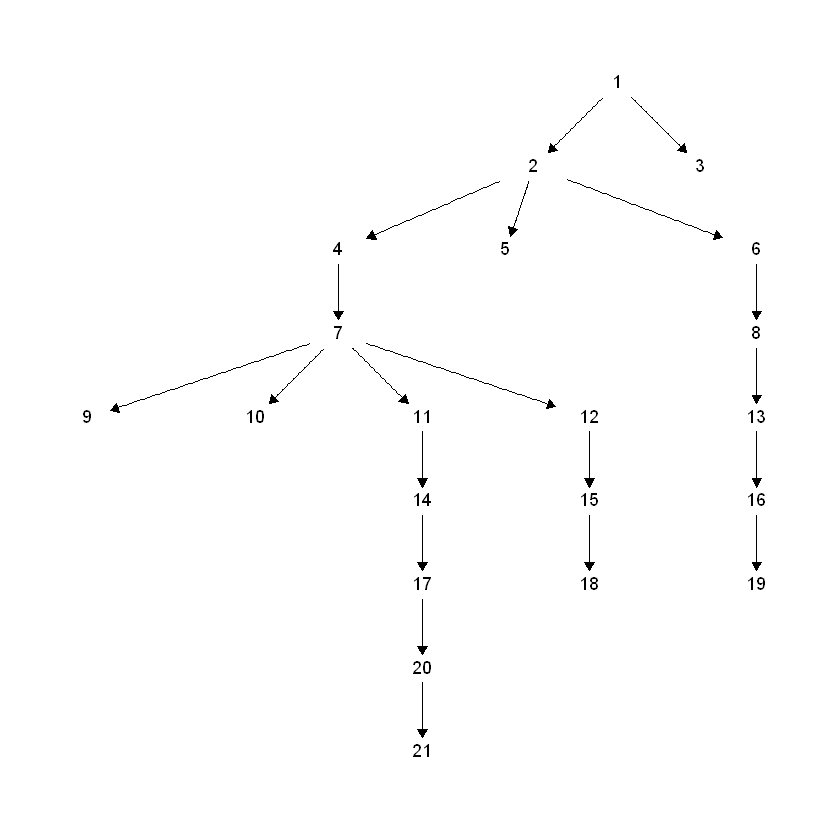

In [19]:
# ggraph inherits syntax of ggplot2
ggraph(graph_tidy) + 
#geom_node_point(fill = NA,
                #alpha = 0.5,
                #size = 2,
                #shape = 1,
                #stroke = 1,
                #fill = "red",
#                colour = "black") + 
geom_edge_link(aes(start_cap = label_rect(node1.label),
                       end_cap = label_rect(node2.label)),
               arrow = arrow(length = unit(0.2, "cm"),
                            type="closed")) + 
geom_node_text(aes(label = id), 
               repel = FALSE) +
theme_graph()

# https://www.data-imaginist.com/2017/ggraph-introduction-nodes/
# https://www.data-imaginist.com/2017/ggraph-introduction-edges/
#https://ggplot2.tidyverse.org/reference/aes_colour_fill_alpha.html

In [406]:
### Find Shortest paths
graph_tidy

# A tbl_graph: 21 nodes and 20 edges
#
# A rooted tree
#
# Node Data: 21 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 55152
3     3 62689
4     4 2680 
5     5 35836
6     6 42009
# ... with 15 more rows
#
# Edge Data: 20 x 3
   from    to   weight
  <int> <int>    <dbl>
1     1     2 2581650.
2     1     3 2581650.
3     2     4 1449882.
# ... with 17 more rows

In [407]:
library(igraph)


Attaching package: 'igraph'

The following object is masked from 'package:plotly':

    groups

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package:tibble':

    as_data_frame

The following object is masked from 'package:tidygraph':

    groups

The following objects are masked from 'package:RBGL':

    bfs, dfs, transitivity

The following objects are masked from 'package:graph':

    degree, edges, intersection, union

The following objects are masked from 'package:BiocGenerics':

    normalize, path, union

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [429]:
allshortestpaths <- all_shortest_paths(graph_tidy,
                                       1,
                                       to = V(graph_tidy),
                                       mode = c("out", "all", "in"),
                                       weights = NULL)
# see https://igraph.org/r/doc/distances.html


In [460]:
t <- allshortestpaths$res[2]
typeof(t)
s<-t[[1]]
typeof(s)
u<-as.integer(s)
u[1]

[1] "list"

[1] "integer"

[1] 1

In [ ]:
### Visual Experiments (interactive)

In [365]:
# code below not working to generate an interactive version
# issues is probably just the Jupyter notebook format...
library(visNetwork)
library(networkD3)
library(htmlwidgets)
library(plotly)

In [318]:
install.packages("visNetwork")
install.packages("htmlwidgets")

Installing package into 'C:/Users/Greig/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'visNetwork' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Greig\AppData\Local\Temp\RtmpCiXsdF\downloaded_packages


In [333]:
#not working in notebook
v<-visNetwork(nodes, edges)

In [335]:
embed_notebook()

ERROR: Error in UseMethod("embed_notebook"): no applicable method for 'embed_notebook' applied to an object of class "NULL"


Installing package into 'C:/Users/Greig/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'htmlwidgets' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Greig\AppData\Local\Temp\RtmpCiXsdF\downloaded_packages
